In [1]:
import logging
# set seed
from pprint import pprint
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
import evaluation as ev
from pathlib import *
import torch
import random
import regex as re
import plot
import matplotlib.pyplot as plt
from sk_models import LocalWeightedRegression, PCR,setup_pls_models_exh,LinearRidge,StandardScaler
import seaborn as sns

from tqdm.notebook import tqdm, trange

In [2]:
seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)

random_state = np.random.RandomState(seed)

In [3]:
#we need to set parametesr
file_name ="A_C_OF_ALPHA.csv"# "A_AL_RT.csv" #"PLN7.csv"
id_cols =['sample_id'] ##["db_id","sample_id"]#["sample_id"]

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/0.02")

In [4]:
data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(log_dir)

data = pd.read_csv(data_file)
data = ut.sample_data(data,random_state)
nrow, ncol = data.shape

n_features = ncol - 1-len(id_cols)
dataset = ut.TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=None, ignore_cols= None)

# todo write a summary
#ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
#tb = SummaryWriter(log_dir/"tb")
print(log_dir)

D:\workspace\lazydeep\experiments\0.02\A_C_OF_ALPHA
D:\workspace\lazydeep\experiments\0.02\A_C_OF_ALPHA


In [5]:
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
eval = ev.CrossValEvaluation(preprocessing=StandardScaler(),tensorboard=None,time=True,random_state=random_state)

In [6]:
def plot_preds_and_res(preds,save_loc = "", name_lambda = lambda x:x,save_lambda = lambda x:x):
    for col_name in preds.columns:
        # plot predictions
        fig, ax = plot.scatter_plot(preds,col_name,"y",color_col="set_id",title= f"Predictions for {name_lambda(col_name)}")
        plt.savefig(save_loc/f"predictions_{save_lambda(col_name)}.png",bbox_inches='tight')
        plt.close()
        # plt.show()

        fig, ax = plot.residual_plot(preds, col_name, "y", color_col="set_id",title = f"Residuals for {name_lambda(col_name)}")
        plt.savefig(save_loc/f"residuals_{save_lambda(col_name)}.png", bbox_inches='tight')
        plt.close()

In [7]:
#setup
scores_df_lwr = None
scores_df_lwr_final = None

save_loc = log_dir/f"LWR"
if not save_loc.exists():
    save_loc.mkdir()

local_logger_name = f"LWR"
ut.setup_logger(logger_name=local_logger_name,file_name=save_loc/f"{local_logger_name}_log.txt")
local_logger = logging.getLogger(local_logger_name)

scheme = ev.SKLearnScheme(logger=local_logger_name)

local_logger.info(f"Running LWR")
scores_sk, preds_sk, model_states_sk , train_time_sk, test_time_sk,_ = eval.evaluate(setup_pls_models_exh(nrow),dataset,scheme,logger_name=local_logger_name)
scores_sk_final, _, model_states_sk_final , _, _,_= eval.build(setup_pls_models_exh(nrow),dataset,scheme,logger_name=local_logger_name)

local_logger.info(f"Train times: {train_time_sk}")
local_logger.info(f"Test times: {test_time_sk}")
local_logger.info(f"Scores: {scores_sk}")
for key,value in ut.flip_dicts(scores_sk).items():
    local_logger.info(f"{key}: {value}")

preds_sk.to_csv(save_loc/ (f"predictions" + ".csv"), index=False)
plot_preds_and_res(preds_sk,name_lambda=lambda x:f"LWR",save_lambda= lambda x:f"lwr",save_loc=save_loc)

flipped = ut.flip_dicts(scores_sk)
#add to scores
for name,record in flipped.items():
    record1 = {'model':f"{name}",'n_comp':n_features}
    if scores_df_lwr is None:
        scores_df_lwr =pd.DataFrame([{**record1,**record}])
    else:
        scores_df_lwr=scores_df_lwr.append([{**record1,**record}],ignore_index=True)

flipped = ut.flip_dicts(scores_sk_final)
#add to scores
for name,record in flipped.items():
    record1 = {'model':f"{name}",'n_comp':n_features}
    if scores_df_lwr_final is None:
        scores_df_lwr_final =pd.DataFrame([{**record1,**record}])
    else:
        scores_df_lwr_final=scores_df_lwr_final.append([{**record1,**record}],ignore_index=True)

Running LWR'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training SKLearn with a train loss of lr:7.731,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.0,lwr_k=200:0.0,lwr_k=300:0.0,lwr_k=400:0.0,lwr_k=500:0.0,lwr_k=600:0.0,lwr_k=700:0.0,lwr_k=800:0.0,lwr_k=900:0.0,lwr_k=1000:0.0'
Tested (test) on 1222 instances with mean losses of: lr:41.6993,lwr_k=10:20.5381,lwr_k=20:16.0058,lwr_k=30:14.787,lwr_k=40:13.7777,lwr_k=50:13.212,lwr_k=100:13.7036,lwr_k=200:18.5196,lwr_k=300:27.2012,lwr_k=400:43.1108,lwr_k=500:61.395,lwr_k=600:104.4146,lwr_k=700:132.7169,lwr_k=800:114.8265,lwr_k=900:84.5645,lwr_k=1000:75.6627'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training SKLearn with a train loss of lr:11.2312,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\huonf\AppData\Local\Temp\ipykernel_92524\3174850488.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df_lwr=scores_df_lwr.append([{**record1,**record}],ignore_index=True)
C:\Users\huonf\AppData\Local\Temp\ipykernel_92524\3174850488.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df_lwr=scores_df_lwr.append([{**record1,**record}],ignore_index=True)
C:\Users\huonf\AppData\Local\Temp\ipykernel_92524\3174850488.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sc

In [8]:
scores_df = scores_df_lwr #pd.concat((scores_df_lr,scores_df_ pcr,scores_df_pls))
scores_df.to_csv(log_dir / f"scores.csv", index=False)

scores_df_final = scores_df_lwr_final#pd.concat((scores_df_lr,scores_df_pcr,scores_df_pls))
scores_df_final.to_csv(log_dir / f"scores_final.csv", index=False)

summary_logger.info("-----------------------------\n"
                    "Rankings\n"
                    "-------------------------------")
scores_df_sorted= scores_df.sort_values("MSE",ascending=True)
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)


-----------------------------
Rankings
-------------------------------'
Rank - model - n_comp - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - lwr_k=40 - 1701 - 13.777734749285903 - 12.129083021046949 - 13.589992357718451 - 11.667717950903876 - 49.35049278244776 - 20.100662729579714 - 0.9096472181008304'
1 - lwr_k=50 - 1701 - 13.21196738465085 - 12.06986659589279 - 14.27930774993541 - 12.42460674695956 - 49.051513269942106 - 20.20497436180324 - 0.9091783357419434'
2 - lwr_k=100 - 1701 - 13.703625210889527 - 15.069295297254445 - 12.505193124930903 - 12.445405657892037 - 49.05862093269541 - 20.55440742321923 - 0.907607628864701'
3 - lwr_k=30 - 1701 - 14.786990986256313 - 12.921306256747458 - 13.133382054117396 - 13.344451020778484 - 50.73468215899551 - 20.981827465454725 - 0.905686369333362'
4 - lwr_k=20 - 1701 - 16.00582243000973 - 14.407736137426742 - 14.175698270708416 - 19.02494499585245 - 52.899407468657635 - 23.30007049567859 - 0.8952658319751161'
5 - lwr_k=200 - 1701 -

In [9]:
#https://stackoverflow.com/questions/22521382/nonlinear-colormap-matplotlib

class nlcmap(object):
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self.transformed_levels = np.linspace(self.levmin, self.levmax, #uniform spacing along levels (colour segments)
             len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self.transformed_levels)
        return self.cmap((yi-self.levmin) / (self.levmax-self.levmin), alpha)

In [10]:
levels = np.concatenate((
    [0, 1],
    [0.6,0.8,0.9,0.95,0.98]
    ))

levels = levels[levels <= 1]
levels.sort()
print(levels)
cmap_nonlin = nlcmap(plt.cm.YlGnBu, levels)

[0.   0.6  0.8  0.9  0.95 0.98 1.  ]


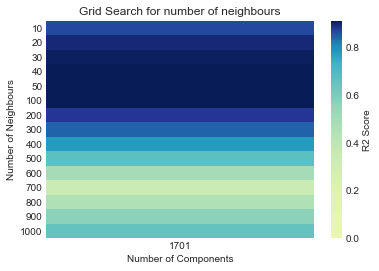

In [11]:
subset = scores_df[["model","n_comp","R2"]]
subset = subset[np.logical_not(subset["model"]=="lr")]
trans = subset["model"].transform(lambda x: int(x.replace("lwr_k=",""))).tolist()

subset.loc[:,"model"]=trans
subset=subset.sort_values("model",ascending=False)
wide = subset.pivot(index = "model",columns= "n_comp",values="R2")

ax = sns.heatmap(wide, linewidth=0.0,vmin=0,center=0,cbar_kws={'label':"R2 Score"},cmap=cmap_nonlin)

ax.set_title("Grid Search for number of neighbours")
ax.set_xlabel("Number of Components")
ax.set_ylabel("Number of Neighbours")

plt.savefig(log_dir/"heatmap.png", bbox_inches='tight')